# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Partición del x_train y el x_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
# Definición de variables
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

Se realiza un ejemplo tomando la columna Mileage como si fuera la mejor

In [6]:
j = 0
print(X.columns[j])

Year


In [7]:
# Hace las particiones a partir de los percentiles
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [8]:
# Puntos donde se va a probar la ganancia de partir el árbol en ese punto
splits = np.unique(splits)

In [9]:
splits

array([1998., 2009., 2011., 2013., 2014., 2015., 2016., 2017.])

Para cada nodo, establecer el Gini.

In [10]:
# Gini, medida de desigualdad. 
# Qué tan disímiles son las dos clases. Lo importante es calcular cuál es la ganancia de hacer esa partición. 
# Si da positivo, es una ganancia.
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [11]:
# Se realiza un ejemplo ta como se hizo en el notebook de clase para mayor entendimiento. Se escoge la posición 6.
k = 6

In [12]:
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [13]:
gini_l = gini(y_l)
gini_l

0.488419737747639

In [14]:
gini_r = gini(y_r)
gini_r

0.12564987217113321

In [15]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split #vector booleano (si pertenece o no al lado izquierdo)
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    # Gini total antes de partir
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [16]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.10990860399601965

#### Probar cada característica

In [17]:
def best_split(X, y, num_pct=10): # num_pct entre màs largo mejores resultados pero mas iteraciones se deben hacer para este caso lo está haciendo de 10 en 10.
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features - se debe probar todo
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [18]:
j, split, gain = best_split(X, y, 10)
j, split, gain

(1, 51704.54545454545, 0.23348567756020572)

In [19]:
X.columns[1] # el split devuelve el resultado de la mejor columna

'Mileage'

Mileage es la mejor característica para abrir el árbol en el primer nivel.

In [20]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [21]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(13150, 8368, 4782)

In [22]:
y.mean(), y_l.mean(), y_r.mean()

(0.5795437262357415, 0.8378346080305927, 0.1275616896695943)

### Construcción del árbol

In [23]:
def tree_grow(X, y, level=0 , min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split calcular la mejor partición en esa variable, devuelve la variable, el valor y la ganancia
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) # antes de partirlo
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction para que nunca vaya a tender a infinito
    
    # Guarda la información como si fuera un nodo terminal
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split # partición 
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain']=gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

Se establecen los criterios para la construcción del árbo: ganancia mínima, máxima profundidad y número de percentiles.

In [24]:
tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': -1,
  'n_samples': 5606,
  'gain': -1},
 'sr': {'y_pred': 0,
  'y_prob': 0.12133499688084841,
  'level': 1,
  'split': -1,
  'n_samples': 3204,
  'gain': -1}}

In [25]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [26]:
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': -1,
    'n_samples': 98,
    'gain': -1},
   'sr': {'y_pred': 0,
    'y_prob': 0.46757679180887374,
    'level': 3,
    'split': -1,
    'n_samples': 291,
    'gain': -1}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8743054224947308,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 5217,
   'gain': 0.014933378976312917,
   'sl': {'y_pred': 1,
    'y_prob': 0.7348484848484849,
    'level': 3,
    'split': -1,
    'n_samples': 1450,
    'gain': -1},
   'sr': {'y_pred': 1,
    'y_prob': 0.92

### Predicción usando x_test

In [27]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [28]:
y_pred=tree_predict(X_test, tree)
print(y_pred)

[0. 1. 1. ... 1. 1. 0.]


In [29]:
from sklearn import tree
from io import StringIO
from IPython.display import Image

In [30]:
#out = StringIO()
#tree.export_graphviz(tree, out_file='tree_grow.dot')

## Uso de sklearn para el cálculo del Accuracy.

In [31]:
from sklearn import metrics
print ('accuracy:',metrics.accuracy_score(y_pred, y_test))


accuracy: 0.8610599078341014


La precisión del árbol de decisión de manera manual para el conjunto de prueba es de 86,1%

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [32]:
import numpy as np
n_estimators = 10
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# Se crean las muestras que serán usadas para seleccionar las filas del dataframe
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [33]:
#Se compurba el tamaño de la muestra
len(samples)

10

In [34]:
#Se crea una variable y_pred donde se va a almacenar la predicción de cada árbol
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

#Se crea un ciclo que va a ir por cada muestra para calcular el respectivo árbol, dentro de este mismo ciclo, se calcula 
#el accuracy para cada árbol
for i in range(n_estimators):
    treeBagg=tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=2, num_pct=10)
    y_pred_df.iloc[:, i] = tree_predict(X_test,treeBagg)
    print ('accuracy arbol:',i,':',metrics.accuracy_score(y_pred, y_test))

accuracy arbol: 0 : 0.8610599078341014
accuracy arbol: 1 : 0.8610599078341014
accuracy arbol: 2 : 0.8610599078341014
accuracy arbol: 3 : 0.8610599078341014
accuracy arbol: 4 : 0.8610599078341014
accuracy arbol: 5 : 0.8610599078341014
accuracy arbol: 6 : 0.8610599078341014
accuracy arbol: 7 : 0.8610599078341014
accuracy arbol: 8 : 0.8610599078341014
accuracy arbol: 9 : 0.8610599078341014


Se observa que el accuracy de cada árbol es de 0.86

In [35]:
y_pred_df.sum(axis=1).head()

332784     2.0
146436    10.0
130476    10.0
85618     10.0
75474      0.0
dtype: float64

In [36]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
metrics.accuracy_score(y_pred, y_test)

0.8608294930875576

Al calcular el accuracy de todo los arboles como uno solo, se observa que este es 0.86 con los 10 árboles

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [37]:
def best_split_features(X, y, num_pct=10,max_features=1): # num_pct entre màs largo mejores resultados pero mas iteraciones se deben hacer para este caso lo está haciendo de 10 en 10.
        
    
    #features = range(X.shape[1])
    features = np.random.choice(a=X.shape[1], size=max_features,replace=False)
    best_split = [0, 0, 0]
    order=np.sort(features)
    #print(order)
    
    # For all features - se debe probar todo
    for j in order:
        #print(j)
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        for split in splits:
            #print(split)
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
                  
    return best_split

In [38]:
def tree_grow_features(X, y, level=0 , min_gain=0.001, max_depth=None, num_pct=10, max_feature=1):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Se agrega la opción max_features al best split, porque está función depende directamente de esta
    #opción al dividir la data de acuerdo al número de características
    j, split, gain = best_split_features(X, y, num_pct, max_feature)
    
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) # antes de partirlo
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction para que nunca vaya a tender a infinito
    
    
    # Guarda la información como si fuera un nodo terminal
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    print(tree)
    print(j)
    print(split)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    #if max_features > X.shape[1]:
    #    return tree
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split # partición 
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain']=gain
    
    # Next iteration to each split
    
    tree['sl'] = tree_grow_features(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_feature=max_feature)
    tree['sr'] = tree_grow_features(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_feature=max_feature)

    
    return tree

In [39]:
#treeFeature = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
treeFeature = tree_grow_features(X_train, y_train, level=0, min_gain=0.001, max_depth=2, num_pct=10, max_feature=7)

{'y_pred': 1, 'y_prob': 0.5780753517930095, 'level': 0, 'split': -1, 'n_samples': 8810, 'gain': -1}
1
52187.63636363637
{'y_pred': 1, 'y_prob': 0.8391583452211127, 'level': 1, 'split': -1, 'n_samples': 5606, 'gain': -1}
0
2014.0
{'y_pred': 0, 'y_prob': 0.36828644501278773, 'level': 2, 'split': -1, 'n_samples': 389, 'gain': -1}
0
2012.0
{'y_pred': 1, 'y_prob': 0.8743054224947308, 'level': 2, 'split': -1, 'n_samples': 5217, 'gain': -1}
1
28003.636363636364
{'y_pred': 0, 'y_prob': 0.12133499688084841, 'level': 1, 'split': -1, 'n_samples': 3204, 'gain': -1}
0
2014.0
{'y_pred': 0, 'y_prob': 0.03787566899958831, 'level': 2, 'split': -1, 'n_samples': 2427, 'gain': -1}
0
2012.0
{'y_pred': 0, 'y_prob': 0.38254172015404364, 'level': 2, 'split': -1, 'n_samples': 777, 'gain': -1}
1
69702.90909090909


In [40]:
y_pred=tree_predict(X_test, treeFeature)
print(y_pred)

[0. 1. 1. ... 1. 1. 0.]


In [41]:
print ('accuracy:',metrics.accuracy_score(y_pred, y_test))

accuracy: 0.8610599078341014


Al realizar el cambio del max_feature se observa que el accuracy cambia entre 0.72, cuando solo tiene un feature hasta 0.86 cuando se utilizan 7 o 9 features.  

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [42]:
import numpy as np
n_estimators = 10
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# Se crean las muestras que serán usadas para seleccionar las filas del dataframe
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [43]:
import math
#Se crea una variable y_pred donde se va a almacenar la predicción de cada árbol con log(n_feature)
y_pred_df_log = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
#Se crea una variable y_pred donde se va a almacenar la predicción de cada árbol con log(n_feature)
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

#Número de features a usar
n_feature=5

#Se crea un ciclo que va a ir por cada muestra para calcular el respectivo árbol, dentro de este mismo ciclo, se calcula 
#el accuracy para cada árbol
for i in range(n_estimators):
    treeBagglog=tree_grow_features(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=2, num_pct=10,max_feature=int(math.log(n_feature)))
    y_pred_df_log.iloc[:, i] = tree_predict(X_test,treeBagglog)
    treeBagg=tree_grow_features(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=2, num_pct=10,max_feature=n_feature)
    y_pred_df_log.iloc[:, i] = tree_predict(X_test,treeBagglog)
    y_pred_df.iloc[:, i] = tree_predict(X_test,treeBagg)
    #print ('accuracy arbol:',i,':',metrics.accuracy_score(y_pred, y_test))

{'y_pred': 1, 'y_prob': 0.5795506128007263, 'level': 0, 'split': -1, 'n_samples': 8810, 'gain': -1}
8
1.0
{'y_pred': 1, 'y_prob': 0.5593714358129515, 'level': 1, 'split': -1, 'n_samples': 7889, 'gain': -1}
7
1.0
{'y_pred': 0, 'y_prob': 0.39822616407982264, 'level': 2, 'split': -1, 'n_samples': 4508, 'gain': -1}
0
0
{'y_pred': 1, 'y_prob': 0.7741649423588531, 'level': 2, 'split': -1, 'n_samples': 3381, 'gain': -1}
1
52407.0
{'y_pred': 1, 'y_prob': 0.7518959913326111, 'level': 1, 'split': -1, 'n_samples': 921, 'gain': -1}
1
62552.909090909096
{'y_pred': 1, 'y_prob': 0.8807947019867549, 'level': 2, 'split': -1, 'n_samples': 753, 'gain': -1}
0
0
{'y_pred': 0, 'y_prob': 0.17647058823529413, 'level': 2, 'split': -1, 'n_samples': 168, 'gain': -1}
0
0
{'y_pred': 1, 'y_prob': 0.5795506128007263, 'level': 0, 'split': -1, 'n_samples': 8810, 'gain': -1}
0
2014.0
{'y_pred': 0, 'y_prob': 0.07711354793066855, 'level': 1, 'split': -1, 'n_samples': 2825, 'gain': -1}
7
1.0
{'y_pred': 0, 'y_prob': 0.0641

{'y_pred': 0, 'y_prob': 0.21908471275559882, 'level': 2, 'split': -1, 'n_samples': 1025, 'gain': -1}
1
51025.0
{'y_pred': 1, 'y_prob': 0.8121537686755078, 'level': 1, 'split': -1, 'n_samples': 5955, 'gain': -1}
1
48409.0
{'y_pred': 1, 'y_prob': 0.885901908475272, 'level': 2, 'split': -1, 'n_samples': 4871, 'gain': -1}
1
30958.0
{'y_pred': 0, 'y_prob': 0.48066298342541436, 'level': 2, 'split': -1, 'n_samples': 1084, 'gain': -1}
1
63502.0
{'y_pred': 1, 'y_prob': 0.5752383113935542, 'level': 0, 'split': -1, 'n_samples': 8810, 'gain': -1}
8
1.0
{'y_pred': 1, 'y_prob': 0.5485801604482363, 'level': 1, 'split': -1, 'n_samples': 7851, 'gain': -1}
0
0
{'y_pred': 1, 'y_prob': 0.7929240374609782, 'level': 1, 'split': -1, 'n_samples': 959, 'gain': -1}
0
0
{'y_pred': 1, 'y_prob': 0.5752383113935542, 'level': 0, 'split': -1, 'n_samples': 8810, 'gain': -1}
3
1.0
{'y_pred': 1, 'y_prob': 0.6826045497888571, 'level': 1, 'split': -1, 'n_samples': 7339, 'gain': -1}
1
51191.818181818184
{'y_pred': 1, 'y_pr

In [44]:
y_pred_df.sum(axis=1).head()

332784     1.0
146436    10.0
130476    10.0
85618     10.0
75474      0.0
dtype: float64

In [45]:
y_pred_df_log.sum(axis=1).head()

332784     5.0
146436    10.0
130476    10.0
85618     10.0
75474      3.0
dtype: float64

In [46]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
metrics.accuracy_score(y_pred, y_test)

0.8610599078341014

In [47]:
y_pred1 = (y_pred_df_log.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
metrics.accuracy_score(y_pred1, y_test)

0.7592165898617511

Usando los bagged trees con el max_features como el log del número de características se  observa que el accuracy disminuye significativamente si se compara con el max_feature sin realizarle ningún calculo. Por ejemplo con 7 como max_features, se obtiene que cuando se usa log(7) el resultado del accuracy es 0.75, mientras que para max_feature=7 es 0.86

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [48]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
clf.fit(X_train, y_train)

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
y_pred1=clf.predict(X_test)

In [51]:
print ('accuracy:',metrics.accuracy_score(y_pred1, y_test))

accuracy: 0.8451612903225807


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [52]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.838325
std       0.011536
min       0.824201
25%       0.828897
50%       0.836502
75%       0.844706
max       0.860076
dtype: float64

Por medio de iteraciones se realiza el cálculo del accuracy para distintos estimdores, donde se selecciona el que obtiene una mayor precisión

In [53]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

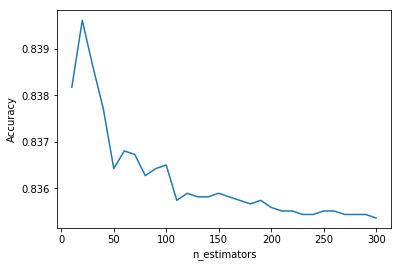

In [54]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

Para este caso se selecciona el número de estimadores en 25

In [55]:
X.shape[1]

9

A partir del n_estimators calculado anteriormente, ahora con un ciclo se procede a calcular cual debe ser el número de features del que se obtiene el mejor accuracy

In [56]:
# list of values to try for max_features
feature_range = range(1, X.shape[1]+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=25, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()) 
    

Text(0, 0.5, 'Accuracy')

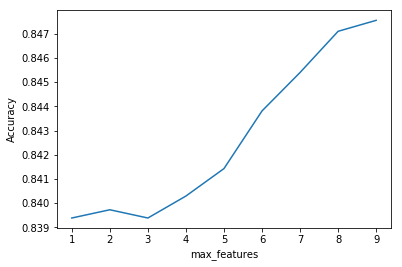

In [57]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Como se observa en el gráfico anterior el mejor accuracy se obtiene para un número de features igual a 9.

In [58]:
# list of values to try for max_depth
depth_range = range(1, 5, 1)
print(depth_range)

range(1, 5)


In [59]:
# list of values to try for max_depth
depth_range = range(1, 10, 1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for depth in depth_range:
    clf = RandomForestClassifier(n_estimators=25, max_features=9,max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5,error_score=np.nan, scoring='accuracy').mean()) 

Text(0, 0.5, 'Accuracy')

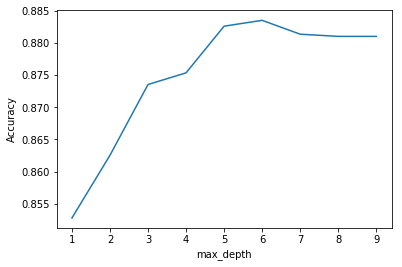

In [60]:
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Con un max_depth de 6 se obtiene el mejor accuracy, por lo que este es el último parámetro de nuestro árbol

In [61]:
clfM = RandomForestClassifier(n_estimators=25, max_features=9, max_depth=6,random_state=1, n_jobs=-1)
clfM.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [62]:
#pd.DataFrame({'feature':, 'importance':clf.feature_importances_}).sort_values('importance')

In [63]:
y_predM=clfM.predict(X_test)

In [64]:
print ('accuracy:',metrics.accuracy_score(y_predM, y_test))

accuracy: 0.8783410138248848


Como se observa al realizar la búsqueda de los parámetros que mejoran el árbol, se obtuvo un aumento en el accuracy del 4%, por lo que se confirma que si se selecciona de manera adecuada los parámetros se puede mejorar el accuracy para nuestro modelo.